In [1]:
import pandas as pd
import numpy as np
import re
import json
import ollama
import chromadb
import time

=============================================
# Pipeline functions
=============================================

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    def interpret_brightness(brightness_level):
        if 0 <= brightness_level <= 100:
            return "dark"
        elif 100 < brightness_level <= 150:
            return "dim"
        elif 150 < brightness_level <= 500:
            return "normal lighting"
        elif 500 < brightness_level <= 1000:
            return "very bright"
        else:
            return "dark"

    def generate_description(row):
        brightness_description = interpret_brightness(row['BrightnessLevel'])
        # return f"{row['UserActivity']} in the {row['Location']} when it is {brightness_description} at {row['Timestamp']}."
        pd.set_option('display.max_colwidth', None)
        description = f"{row['UserActivity']} in the {row['Location']} at {row['Timestamp']} when it is {brightness_description}."
        return description

    df['Description'] = df.apply(generate_description, axis=1)

    # only use the lastest state
    df_latest = df.iloc[-1:]
    df_latest = df_latest['Description']
    df_latest = df_latest.to_string(index=False)
    # print(df_latest)

    # use last 10 states
    df_history = df.iloc[-10:]
    df_history = df_history['Description']
    df_history = df_history.to_string(index=False)
    # print(df_history)

    return df_latest, df_history

def extract_json_from_response(response_text):
    """
    Extracts the JSON object from the assistant's response.
    """
    import json

    brace_count = 0
    json_start = None

    for i, char in enumerate(response_text):
        if char == '{':
            if brace_count == 0:
                json_start = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and json_start is not None:
                json_str = response_text[json_start:i+1]
                try:
                    # Try to parse the extracted string
                    json.loads(json_str)
                    return json_str
                except json.JSONDecodeError:
                    pass  # Continue searching for valid JSON
    raise ValueError("No valid JSON object found in the assistant's response.")


    
def LLM2(knowledge_base, df_latest, collection, df_history, light_status):

    user_query = f"""
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. light5 is the main light in the dining room next to living room closely.
    Now the light status is {light_status}, recent user behaviors are: {df_history}tell me Which lights should be turned on/off while the user is {df_latest}? "
    """ 

    print("User Query:")
    print(user_query)

    query_response = ollama.embeddings(
        prompt=user_query,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results= 30  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt = f"""
You are an AI smart home assistant.

Your task is to determine the appropriate light control actions based on the user's current situation and preferences.

**Instructions:**

1. **Analyze the user's current situation:**
   - Activity: {df_latest}
   - Current light status: {light_status}
   - Recent user behaviors: {df_history}
   consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.

2. **Refer to the knowledge base entries below to understand the user's preferences:**
{data}

3. **Determine the appropriate light control actions:**
   - Map the user's activity to their preferences.
   - Decide which lights should be turned on or off based on these preferences.

4. **Output the light control actions in the fixed JSON format below:**

```json
{{
    "description": "{df_latest}",
    "light1": "on/off",
    "light2": "on/off",
    "light3": "on/off",
    "light4": "open/close",
    "light5": "on/off"
}}
    """

    output = ollama.generate(
        # model="qwen2.5:7b",
        model ="qwen2.5:14b-instruct",
        prompt=final_prompt
    )


    assistant_response = output['response']

    print("Assistant's Response:")
    print(assistant_response)

    try:
        # Extract JSON code block if the assistant included any text before or after
        json_code = extract_json_from_response(assistant_response)

        # Parse the JSON string
        actions = json.loads(json_code)

        # Remove the "description" key if not needed
        actions.pop("description", None)

        print("\nExtracted Light Control Actions:")
        print(actions)

        return actions

    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Handle the error or return None
        return None



def LLM1(df_latest, user_feedback, actions, df_history, collection):
    print("User Feedback:")
    print(user_feedback)
    
    user_update = f"""
    You are a smart home assistant responsible for deciding if to update the lighting knowledge based on user manually changes to the light states. 
    The user manually change the current light status from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    Considering recent user behaviors, there are some trasition activities (between 2 steady activities), so decide if to update the knowledge base based on the user feedback and recent behaviors.
    """

    query_response = ollama.embeddings(
        prompt=user_update,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results=8  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt_update = f"""
    You are a smart home assistant.

    Based on the retrieved current knowledge base entries:
    {data}

    Consider current situation:
    {user_update}

    Decide if to update the knowledge base in the fixed json format:
    {{
    "Update": "yes/no"  
    }}

    Provide the updated knowledge base in the fixed json format:
    {{
        "{df_latest}:",
        "light1": "on/off",
        "light2": "on/off",
        "light3": "on/off",
        "light4": "open/close",
        "light5": "on/off",

    }}
    """

    ## LLM1
    output = ollama.generate(
    model="qwen2.5:14b-instruct",
    prompt=final_prompt_update
    )

    print("Assistant's Response:")
    print(output['response'])

    knowledge_base_text = output['response']
    # print(knowledge_base_text)
    return knowledge_base_text


def extract_json_objects(text):
    """
    Extracts all JSON objects from the text.
    """
    json_objects = []
    brace_stack = []
    in_json = False
    json_start = 0

    for i, char in enumerate(text):
        if char == '{':
            if not in_json:
                json_start = i
                in_json = True
            brace_stack.append('{')
        elif char == '}':
            if brace_stack:
                brace_stack.pop()
                if not brace_stack:
                    # Found a complete JSON object
                    json_str = text[json_start:i+1]
                    json_objects.append(json_str)
                    in_json = False
        else:
            continue

    return json_objects

def update_knowledge_base(knowledge_base, knowledge_base_update):
    code_block_pattern = r'```json\s*([\s\S]*?)```'
    json_blocks = re.findall(code_block_pattern, knowledge_base_update)

    if not json_blocks:
        # Try to find any JSON objects in the text
        # json_blocks = re.findall(r'\{(?:[^{}]|(?R))*\}', knowledge_base_update)
        json_blocks = extract_json_objects(knowledge_base_update)

    update_decision = None
    updated_kb = None

    for idx, json_str in enumerate(json_blocks):
        print(f"\nExtracted JSON String {idx+1}:")
        print(json_str)

        # Clean up the JSON string
        json_str = json_str.strip()
        json_str = re.sub(r',\s*}', '}', json_str)  # Remove trailing commas before }
        json_str = re.sub(r',\s*\]', ']', json_str)  # Remove trailing commas before ]

        # Parse the JSON string
        try:
            json_data = json.loads(json_str)

            if "Update" in json_data:
                update_decision = json_data.get("Update")
                print(f"\nParsed Update Decision: {update_decision}")

                json_data.pop("Update", None)

                if json_data:
                    updated_kb = json_data
                    print("\nParsed Updated Knowledge Base:")
                    print(json.dumps(updated_kb, indent=2))
            else:
                updated_kb = json_data
                print("\nParsed Updated Knowledge Base:")
                print(json.dumps(updated_kb, indent=2))
        except json.JSONDecodeError as e:
            print(f"\nFailed to parse JSON in block {idx+1}: {e}")

    # Process the extracted data
    if update_decision is not None:
        print(f"\nUpdate Decision: {update_decision}")
        if update_decision.lower() == "yes":
            if updated_kb is not None:
                # light_status = updated_kb.get("description")
                knowledge_base = knowledge_base + "\n" + json.dumps(updated_kb, indent=2)
                print("\nKnowledge base has been updated.")
            else:
                print("\nNo updated knowledge base provided.")
        else:
            print("\nKnowledge base remains unchanged.")
    else:
        print("\nThe 'Update' decision was not found in the LLM's output.")

    return knowledge_base, update_decision


def get_user_confidence():
    confidence_input = input("Please rate your confidence in the system on a scale from 0 to 1: ")
    try:
        confidence = float(confidence_input)
        if 0 <= confidence <= 1:
            return confidence
        else:
            print("Invalid input. Confidence should be between 0 and 1.")
            return get_user_confidence()
    except ValueError:
        print("Invalid input. Please enter a number between 0 and 1.")
        return get_user_confidence()

knowledge_base = """
    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.

    Prefer a bright environment while grooming.
"""

In [7]:
knowledge_base = """
    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.
{
  "eating in the living room at 10:20:00 when it is very bright": {
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
  }
}
{
  "sitting in the living room at 10:20:30 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "open",
    "light5": "off"
  }
}
{
  "standing in the living room at 10:20:30 when it is very bright": {
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "open",
    "light5": "on"
  }
}
{
  "exercising in the living room at 10:20:30 when it is very bright": {
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
  }
}
{
  "video gaming in the living room at 10:21:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "on",
    "light4": "open",
    "light5": "off"
  }
}
{
  "housekeeping in the living room at 10:21:00 when it is very bright": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "open",
    "light5": "off"
  }
}
{
  "drinking in the living room at 10:21:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "on",
    "light5": "off"
  }
}
{
  "walking in the living room at 10:21:00 when it is very bright.": {
    "light1": "off",
    "light2": "off",
    "light3": "off",
    "light4": "open",
    "light5": "off"
  }
}
{
  "watching tv in the living room at 10:21:00 when it is very bright.": {
    "light1": "off",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
"""

=============================================
# Pipeline Main
=============================================

In [22]:
documents = knowledge_base.split('\n\n')
documents = [' '.join(doc.split()) for doc in documents]

client = chromadb.Client()

try:
    collection = client.get_collection("docs")
    print("Collection already exists.")
except Exception as e:
    # If the collection does not exist, create it
    collection = client.create_collection(name="docs")
    print("Collection created.")

# store each document in a vector embedding database
for i, d in enumerate(documents):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=d)
    embedding = response["embedding"]
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        documents=[d]
    )


def main():
    global knowledge_base
    previous_df_latest = None

    user = "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = LLM2(knowledge_base, df_latest, collection, df_history, light_status)
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "on", "light2": "on", "light3": "off", "light4": "close", "light5": "on"}
            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    # user_feedback = None
                    continue
            else:
                user_feedback = None

            if user_feedback:
                user_condidence = get_user_confidence()
                # if user_condidence < 0.5:
                #     # use RL agent to update the knowledge base
                #     print("RL agent to update the knowledge base")
                #     knowledge_base = rl_agent_update(knowledge_base, user_feedback, actions, df_history)

                # else:

                knowledge_base_update = LLM1(
                    df_latest=df_latest,
                    user_feedback=user_feedback,
                    actions=actions,
                    df_history=df_history,
                    collection=collection)
                
                knowledge_base, update_decision = update_knowledge_base(knowledge_base, knowledge_base_update)
                print("\nUpdated Knowledge Base:")
                print(knowledge_base)

                if update_decision == "yes":
                    light_status = user_feedback
                    print("\nUpdated Light Status:")
                    print(light_status)
                else:
                    print("\nLight Status remains unchanged.")
                    light_status = actions

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main()

Collection already exists.


Insert of existing embedding ID: 0
Add of existing embedding ID: 0
Insert of existing embedding ID: 1
Add of existing embedding ID: 1
Insert of existing embedding ID: 2
Add of existing embedding ID: 2
Insert of existing embedding ID: 3
Add of existing embedding ID: 3
Insert of existing embedding ID: 4
Add of existing embedding ID: 4
Insert of existing embedding ID: 5
Add of existing embedding ID: 5
Insert of existing embedding ID: 6
Add of existing embedding ID: 6
Insert of existing embedding ID: 7
Add of existing embedding ID: 7
Insert of existing embedding ID: 8
Add of existing embedding ID: 8
Insert of existing embedding ID: 9
Add of existing embedding ID: 9
Insert of existing embedding ID: 10
Add of existing embedding ID: 10
Insert of existing embedding ID: 11
Add of existing embedding ID: 11
Insert of existing embedding ID: 12
Add of existing embedding ID: 12
Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the sofa at 10:21:30 when it is very bright.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: watching tv in the sofa at 10:08:00 when it is very bright.
watching tv in the sofa at 10:10:00 when it is very bright.
watching tv in the sofa at 10:12:00 when it is very bright.
watching tv in the sofa at 10:14:00 when it is very bright.
watching tv in the sofa at 10:16:00 when it is very bright.
watching tv in the sofa at 10:18:00 when it is very bright.
watching tv in the sofa at 10:20:00 when it is very bright.
watching tv in the sofa at 10:20:30 when it 

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright environment while grooming. { "eating in the living room at 10:20:00 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "close", "light5": "off" } } { "sitting in the living room at 10:20:30 when it is very bright.": { "light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off" } } { "standing in the living room at 10:20:30 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "open", "light5": "on" } } { "exercising in the living room at 10:20:30 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "close", "light5": "off" } } { "video gaming in the living room at 10:21:00 when it is very bright.": { "light1": "off", "light2": "off", "light3": "on", "light4": "open", "light5": "off" } } { "housekeeping in the living room at 10:21:00 when it is very bright": { "light1": "off", "light2": "off", "light3": "off", "light4": "open", "light

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a bright environment while grooming. { "eating in the living room at 10:20:00 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "close", "light5": "off" } } { "sitting in the living room at 10:20:30 when it is very bright.": { "light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off" } } { "standing in the living room at 10:20:30 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "open", "light5": "on" } } { "exercising in the living room at 10:20:30 when it is very bright": { "light1": "on", "light2": "on", "light3": "on", "light4": "close", "light5": "off" } } { "video gaming in the living room at 10:21:00 when it is very bright.": { "light1": "off", "light2": "off", "light3": "on", "light4": "open", "light5": "off" } } { "housekeeping in the living room at 10:21:00 when it is very bright": { "light1": "off", "light2": "off", "light3": "off", "light4": "open", "light

KeyboardInterrupt: 

In [12]:
print(knowledge_base)  


    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.

    Prefer a bright environment while grooming.

{
  "video gaming in the sofa at 20:18:00 when it is dark": {
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
  }
}


=============================================
# 0-Shot
=============================================

In [27]:
delete_query = '''
    This is the preference of user1 Richard:

    Richard likes a bright environment.

    Richard requires a dimly lit while watching TV.

    Richard requires a dimly lit environment while reading books.

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while eating.

    Richard requires a dimly lit environment while playing video games.

    Richard requires a dark environment while sleeping (lying). 

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while housekeeping.

    Richard requires a dimly lit environment while working (typing).

    Richard requires a dimly lit environment while sitting.

    Richard requires a bright environment while cooking.

    Richard requires a bright environment while grooming.
    '''

def zero_shot(user, df_latest, user_feedback, df_history, actions, light_status):
    print("User Feedback:")
    print(user_feedback)
    
    user_query = f"""
    {user} is the user who is living in this apartment. 

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a dimming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. Dining room is next to living room, light5 is the main light in the dining room.
    Now the current light status is {light_status}.
    Tell me Which lights should be turned on/off while the user is {df_latest}? "
    Then based on the user feedback: {user_feedback} and recent user behaviors: {df_history}, decide which lights should be turned on/off.

    The user manually changed the light state from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.
    Considering recent user behaviors, decide if to update the light status base based on the user feedback.
    """

    final_prompt = f"""
    You are a smart home assistant.

    Respond to the user's current situation:
    {user_query}

    Provide the light control actions in the fixed format:
    {{
    "1.": {{
        "description": "{df_latest}",
        "light1": "on/off",
        "light2": "on/off",
        ...
    }},
    ...
    }}
    """

    output = ollama.generate(
        # model="qwen2.5:7b",
        model ="qwen2.5:14b-instruct",
        prompt=final_prompt
    )

    assistant_response = output['response']

    print("Assistant's Response:")
    print(assistant_response)

    try:
        # Extract JSON code block if the assistant included any text before or after
        json_code = extract_json_from_response(assistant_response)

        # Parse the JSON string
        actions = json.loads(json_code)

        # Remove the "description" key if not needed
        actions.pop("description", None)

        print("\nExtracted Light Control Actions:")
        print(actions)

        return actions

    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Handle the error or return None
        return None
    

def main_zeroshot():
    global knowledge_base
    previous_df_latest = None
    user = "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = zero_shot(
                user = user,
                df_latest = df_latest,
                user_feedback = None,
                df_history = None,
                actions = None,
                light_status = light_status)
            
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off"}
        
            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    user_feedback = None
            else:
                user_feedback = None

            light_status = actions

            actions_feedback = zero_shot(
                user=user,
                df_latest=df_latest,
                user_feedback=user_feedback,
                df_history=df_history,
                actions=actions,
                light_status=actions)
            
            print("\nUpdated Action:")
            print(actions_feedback)

            light_status = actions_feedback

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main_zeroshot()

description changed
standing in the living room at 10:21:30 when it is very bright.
User Feedback:
None
Assistant's Response:
Given that Richard is standing in the living room and it's described as being very bright, there isn't a strong need to turn on lights unless he specifically requires some. However, since light1 has multiple color temperatures, it might be useful for setting an appropriate ambiance or specific task lighting. Considering this situation:

- The main light (light1) can be turned on at neutral brightness to provide general illumination if needed.
- Since the curtains are closed and it's very bright outside, there isn't a need to open them immediately unless he wants more sunlight.

Here is how I would suggest adjusting the lights based on his current situation:

{
    "1.": {
        "description": "standing in the living room at 10:21:30 when it is very bright.",
        "light1": "on",
        "light2": "off",
        "light3": "off",
        "light4": "close",  


KeyboardInterrupt: 

=============================================
# Chain of Thought
=============================================

In [28]:
delete_query = '''
    This is the preference of user1 Richard:

    Richard likes a bright environment.

    Richard requires a dimly lit while watching TV.

    Richard requires a dimly lit environment while reading books.

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while eating.

    Richard requires a dimly lit environment while playing video games.

    Richard requires a dark environment while sleeping (lying). 

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while housekeeping.

    Richard requires a dimly lit environment while working (typing).

    Richard requires a dimly lit environment while sitting.

    Richard requires a bright environment while cooking.

    Richard requires a bright environment while grooming.
    '''

def cot(user, df_latest, user_feedback, df_history, actions, light_status):
    print("User Feedback:")
    print(user_feedback)
    
    user_query = f"""
    {user} is the user who is living in this apartment.
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a dimming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. Dining room is next to living room, light5 is the main light in the dining room.
    Now the current light status is {light_status}.
    Tell me Which lights should be turned on/off while the user is {df_latest}? "
    Then based on the user feedback: {user_feedback} and recent user behaviors: {df_history}, decide which lights should be turned on/off.

    The user manually changed the light state from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.
    Considering recent user behaviors, decide if to update the lights base based on the user feedback.

    Provide your reasoning step by step.
    """

    final_prompt = f"""
    You are a smart home assistant.

    Respond to the user's current situation:
    {user_query}

    Provide the light control actions in the fixed format:
    {{
    "1.": {{
        "description": "{df_latest}",
        "light1": "on/off",
        "light2": "on/off",
        ...
    }},
    ...
    }}
    """

    output = ollama.generate(
        # model="qwen2.5:7b",
        model ="qwen2.5:14b-instruct",
        prompt=final_prompt
    )

    assistant_response = output['response']

    print("Assistant's Response:")
    print(assistant_response)

    try:
        # Extract JSON code block if the assistant included any text before or after
        json_code = extract_json_from_response(assistant_response)

        # Parse the JSON string
        actions = json.loads(json_code)

        # Remove the "description" key if not needed
        actions.pop("description", None)

        print("\nExtracted Light Control Actions:")
        print(actions)

        return actions

    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Handle the error or return None
        return None
    

def main_cot():
    global knowledge_base
    previous_df_latest = None
    user =  "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = cot(
                user = user,
                df_latest = df_latest,
                user_feedback = None,
                df_history = None,
                actions = None,
                light_status = light_status)
            
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off"}
        

            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    user_feedback = None
            else:
                user_feedback = None

            actions_feedback = cot(
                user=user,
                df_latest=df_latest,
                user_feedback=user_feedback,
                df_history=df_history,
                actions=actions,
                light_status=actions)
            
            print("\nUpdated Action:")
            print(actions_feedback)

            light_status = actions_feedback

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main_cot()

description changed
standing in the living room at 10:21:30 when it is very bright.
User Feedback:
None
Assistant's Response:
Given that it's very bright outside, let's consider what would be most comfortable for Richard in the living room. Since the lights are currently off and the curtains are closed, we need to decide which lights should be turned on based on brightness levels.

1. **light1 (Main Light with 3 color temperatures)**: If it is very bright outside, turning on light1 might not be necessary as natural light would already provide illumination. However, since the user is standing in the room and there's no indication of using a specific task-oriented light like light2 or light3, we can assume that some ambient lighting could help adjust to indoor activities.

2. **light2 (Dimming Light above TV)**: This light might be useful if Richard is planning to watch something on the TV but wants to keep the room bright due to the outside conditions. However, it’s more likely that he 

KeyboardInterrupt: 

=============================================
# ReACT
=============================================

In [25]:
delete_query = '''
    This is the preference of user1 Richard:

    Richard likes a bright environment.

    Richard requires a dimly lit while watching TV.

    Richard requires a dimly lit environment while reading books.

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while eating.

    Richard requires a dimly lit environment while playing video games.

    Richard requires a dark environment while sleeping (lying). 

    Richard requires a bright environment while exercising.

    Richard requires a bright environment while housekeeping.

    Richard requires a dimly lit environment while working (typing).

    Richard requires a dimly lit environment while sitting.

    Richard requires a bright environment while cooking.

    Richard requires a bright environment while grooming.
    '''

def react(user, df_latest, user_feedback, df_history, actions, light_status):
    print("User Feedback:")
    print(user_feedback)
    
    user_query = f"""

    {user} is the user who is living in this apartment.
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a dimming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. Dining room is next to living room, light5 is the main light in the dining room.
    Now the current light status is {light_status}.
    Tell me Which lights should be turned on/off while the user is {df_latest}? "
    Then based on the user feedback: {user_feedback} and recent user behaviors: {df_history}, decide which lights should be turned on/off.

    The user manually changed the light state from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.
    Considering recent user behaviors, decide if to update the lights base based on the user feedback.
    
    Determine which lights should be turned on/off while the user is **{df_latest}**, considering the user preferences, lighting setup, user feedback, and recent user behaviors.
    For each step, first provide your reasoning, then specify any action you would take (e.g., "Action: [describe action]").
    If you need to recall user preferences or recent behaviors, indicate that you are accessing that information.
    After reasoning and actions, provide the final light control actions in the fixed format.
    """

    final_prompt = f"""
    You are a smart home assistant.

    Respond to the user's current situation:
    {user_query}

    Provide the light control actions in the fixed format:
    {{
    "1.": {{
        "description": "{df_latest}",
        "light1": "on/off",
        "light2": "on/off",
        ...
    }},
    ...
    }}
    """

    output = ollama.generate(
        # model="qwen2.5:7b",
        model ="qwen2.5:14b-instruct",
        prompt=final_prompt
    )

    actions = output['response']

    print("Assistant's Response:")
    print(actions)

    return actions

def main_react():
    global knowledge_base
    previous_df_latest = None
    user = "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = react(
                user = user,
                df_latest = df_latest,
                user_feedback = None,
                df_history = None,
                actions = None,
                light_status = light_status)
            
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off"}
        

            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    user_feedback = None
            else:
                user_feedback = None

            actions_feedback = react(
                user=user,
                df_latest=df_latest,
                user_feedback=user_feedback,
                df_history=df_history,
                actions=actions,
                light_status=actions)
            
            print("\nUpdated Action:")
            print(actions_feedback)

            light_status = actions_feedback

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main_react()

description changed
standing in the living room at 10:21:30 when it is very bright.
User Feedback:
None
Assistant's Response:
Given that Richard is standing in the living room at 10:21:30 and it is very bright outside, we need to determine which lights should be turned on or off.

### Reasoning:
- **light1**: This is the main light with three color temperatures (warm, neutral, cool). Since it is very bright, a warm setting might not be necessary. However, since all lights are currently off and it's daytime, this could serve as an ambient light at low brightness.
- **light2**: A dimming light above the TV. This can help soften the brightness in that specific area but isn't crucial when it is very bright outside already.
- **light3**: A lamp on a table; useful for reading or task lighting. Given the bright conditions, this might not be necessary at full power.
- **light4**: A curtain mechanism which could reduce direct sunlight. Since the curtains are currently closed (status: close), op

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['2nd and 3rd Round']
accuracy_data = {
    'zero-shot': [0.63],
    'CoT': [0.68],
    'ReAct': [0.75],
    'Single RAG': [0.90],
    'UbiLLM': [0.95]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
plt.xlabel('Differences between rounds')
plt.ylabel('Accuracy')
plt.title('Differences between groups (Steady Activities)')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.legend()
plt.savefig('TAP_accuracy_compare.svg')
plt.show()

=============================================
# RAG
=============================================

In [3]:
knowledge_base = """
    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.

    Prefer a bright environment while grooming.
{
  "walking in the living room at 12:48:00 when it is dark.": {
    "light1": "on",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "eating in the sofa at 22:28:00 when it is dark.": {
    "light1": "on",
    "light2": "off",
    "light3": "off",
    "light4": "close",
    "light5": "on"
  }
}
{
  "watch tv in the sofa at 21:26:00 when it is dark.": {
    "light1": "off",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "lying in the sofa at 21:04:00 when it is dark.": {
    "light1": "off",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
  }
}
{
  "video gaming in the sofa at 21:04:00 when it is dark.": {
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
  }
}
{
  "reading in the sofa at 21:04:00 when it is dark.": {
    "light1": "on",
    "light2": "off",
    "light3": "on",
    "light4": "close",
    "light5": "off"
  }
}
{
  "exercising in the sofa at 21:04:00 when it is dark.": {
    "light1": "on",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "on"
  }
}
"""

In [24]:
documents = knowledge_base.split('\n\n')
documents = [' '.join(doc.split()) for doc in documents]

client = chromadb.Client()

try:
    collection = client.get_collection("docs")
    print("Collection already exists.")
except Exception as e:
    # If the collection does not exist, create it
    collection = client.create_collection(name="docs")
    print("Collection created.")

# store each document in a vector embedding database
for i, d in enumerate(documents):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=d)
    embedding = response["embedding"]
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        documents=[d]
    )

def rag(user, df_latest, collection, df_history, actions, user_feedback):
    print("User Feedback:")
    print(user_feedback)

    user_query = f"""
    {user} is the user who is living in this apartment. Based on the Layout of lights in the living room, 
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a dimming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. Dining room is next to living room, light5 is the main light in the dining room.
    Tell me Which lights should be turned on/off while the user is {df_latest}? "
    Then based on the user feedback: {user_feedback} and recent user behaviors: {df_history}, decide which lights should be turned on/off.

    The user manually changed the light state from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    Decide if to update the knowledge base based on the user feedback and recent behaviors.
    consider the recent user behaviors, there are some trasitional phase, like from eating to sitting to eating, sitting only lasts for a very short period of time, so dont have to update sitting, here dont update knowledge base of sitting decide which lights should be turned on or off based on these preferences.
    """

    print("User Query:")
    print(user_query)

    query_response = ollama.embeddings(
        prompt=user_query,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results=10  # Retrieve top 3 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt = f"""
    You are a smart home assistant.

    1. **Analyze the user's current situation:**
    - Activity: {df_latest}
    - Recent user behaviors: {df_history}

    2. **Refer to the knowledge base entries below to understand the user's preferences:**
    {data}

    3. **Determine the appropriate light control actions:**
    - Map the user's activity to their preferences.
    - Decide which lights should be turned on or off based on these preferences.

    4. **Output the light control actions in the fixed JSON format below:**

    ```json
    {{
        "description": "{df_latest}",
        "light1": "on/off",
        "light2": "on/off",
        "light3": "on/off",
        "light4": "open/close",
        "light5": "on/off"
    }}

    Decide if to update the knowledge base in the fixed json format:
    {{
    "Update": "yes/no"  
    }}

    Provide the updated knowledge base in the fixed json format:
    {{
    "1.": {{
        "description": "{df_latest}",
        "lightx": "on/off",
        "lightx": "on/off",
        ...
    }},
    ...
    }}

    """

    output = ollama.generate(
        # model="qwen2.5:7b",
        model ="qwen2.5:14b-instruct",
        prompt=final_prompt
    )

    actions = output['response']

    print("Assistant's Response:")
    print(actions)

    return actions


def main_rag():
    global knowledge_base
    previous_df_latest = None

    actions = None
    user_feedback = None

    user = "Richard"

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = rag(
                user = user,
                df_latest=df_latest,
                collection=collection,
                df_history=df_history,
                actions=actions,
                user_feedback=user_feedback)
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "off", "light2": "off", "light3": "off", "light4": "open", "light5": "off"}
            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    # user_feedback = None
                    continue
            else:
                user_feedback = None

            if user_feedback:
                user_condidence = get_user_confidence()
                # if user_condidence < 0.5:
                #     # use RL agent to update the knowledge base
                #     print("RL agent to update the knowledge base")
                #     knowledge_base = rl_agent_update(knowledge_base, user_feedback, actions, df_history)

                # else:

                knowledge_base_update = LLM1(
                    df_latest=df_latest,
                    user_feedback=user_feedback,
                    actions=actions,
                    df_history=df_history,
                    collection=collection)
                
                knowledge_base, update_decision = update_knowledge_base(knowledge_base, knowledge_base_update)
                print("\nUpdated Knowledge Base:")
                print(knowledge_base)
                print("\nUpdated Knowledge Base:")
                print(knowledge_base)


            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main_rag()

Collection already exists.


Insert of existing embedding ID: 0
Add of existing embedding ID: 0
Insert of existing embedding ID: 1
Add of existing embedding ID: 1
Insert of existing embedding ID: 2
Add of existing embedding ID: 2
Insert of existing embedding ID: 3
Add of existing embedding ID: 3
Insert of existing embedding ID: 4
Add of existing embedding ID: 4
Insert of existing embedding ID: 5
Add of existing embedding ID: 5
Insert of existing embedding ID: 6
Add of existing embedding ID: 6
Insert of existing embedding ID: 7
Add of existing embedding ID: 7
Insert of existing embedding ID: 8
Add of existing embedding ID: 8
Insert of existing embedding ID: 9
Add of existing embedding ID: 9
Insert of existing embedding ID: 10
Add of existing embedding ID: 10
Insert of existing embedding ID: 11
Add of existing embedding ID: 11
Insert of existing embedding ID: 12
Add of existing embedding ID: 12


description changed
standing in the living room at 10:21:30 when it is very bright.
User Feedback:
None
User Query:

    Richard is the user who is living in this apartment. Based on the Layout of lights in the living room, 
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a dimming light above the TV. light3 is a lamp on the table. light4 a curtain on the window. Dining room is next to living room, light5 is the main light in the dining room.
    Tell me Which lights should be turned on/off while the user is standing in the living room at 10:21:30 when it is very bright.? "
    Then based on the user feedback: None and recent user behaviors: housekeeping in the living room at 10:08:00 when it is very bright.
housekeeping in the living room at 10:10:00 when it is very bright.
housekeeping in the living room at 10:12:00 when it is very bright.
housekeeping in the living room at 10:14:00 when it is very 

KeyboardInterrupt: 

# results plot

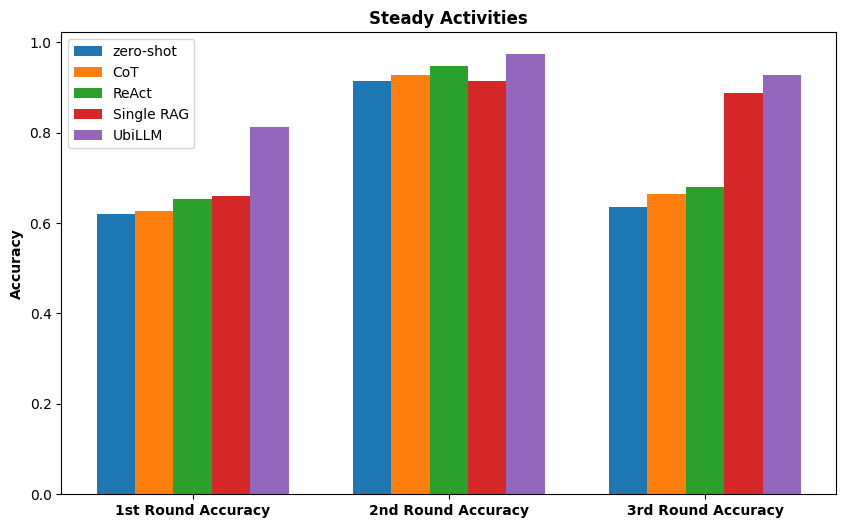

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['1st Round Accuracy', '2nd Round Accuracy', '3rd Round Accuracy']
accuracy_data = {
    # 'zero-shot': [0.6530, 0.927, 0.680],
    # 'ReAct': [0.6530, 0.927, 0.680],
    'zero-shot': [0.62, 0.915, 0.635],
    'CoT': [0.627, 0.927, 0.663],
    'ReAct':[0.6530, 0.947, 0.680],
    'Single RAG': [0.66, 0.913, 0.887],
    'UbiLLM': [0.813, 0.973, 0.927]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Accuracy of each round')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Steady Activities', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('TAP_accuracy_steady.pdf')
plt.show()

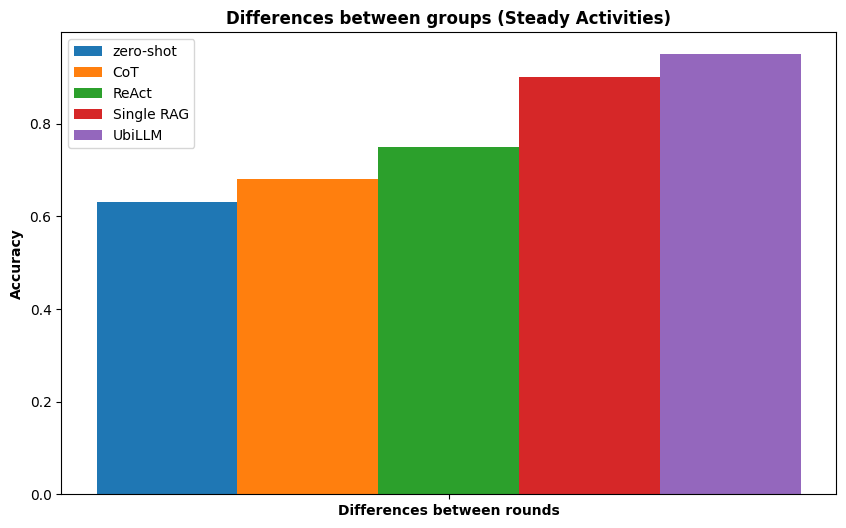

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['Differences between rounds']
accuracy_data = {
    'zero-shot': [0.63],
    'CoT': [0.68],
    'ReAct': [0.75],
    'Single RAG': [0.90],
    'UbiLLM': [0.95]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Differences between rounds')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Differences between groups (Steady Activities)', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('TAP_accuracy_compare.pdf')
plt.show()

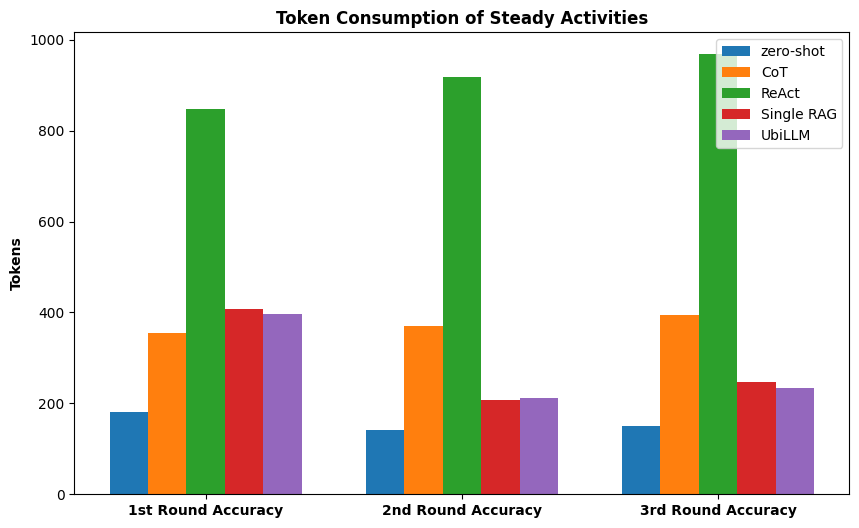

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['1st Round Accuracy', '2nd Round Accuracy', '3rd Round Accuracy']
accuracy_data = {
    'zero-shot': [180, 141, 151],
    'CoT': [354, 371, 394],
    'ReAct': [848, 917, 968],
    'Single RAG': [407, 207, 248],
    'UbiLLM': [396, 212, 233]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Token consumption of each round')
plt.ylabel('Tokens', fontweight='bold')
plt.title('Token Consumption of Steady Activities', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('TAP_token_steady.pdf')
plt.show()

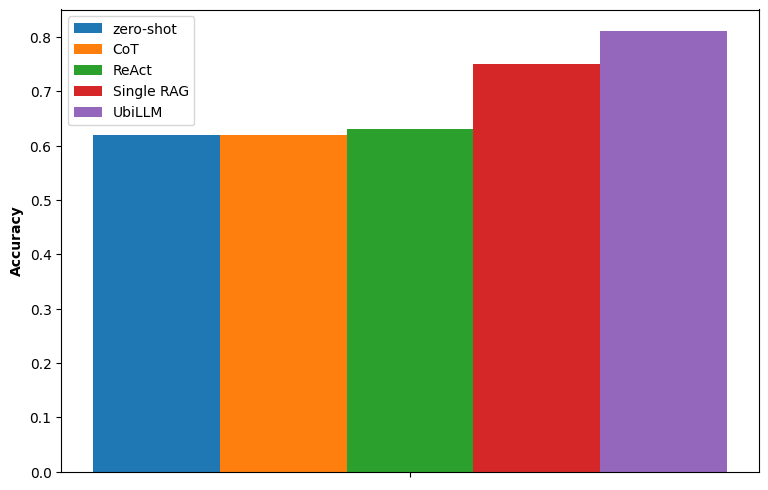

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['']
accuracy_data = {
    'zero-shot': [0.62],
    'CoT': [0.62],
    'ReAct': [0.63],
    'Single RAG': [0.75],
    'UbiLLM': [0.81] 
}

# Number of methods
num_methods = len(methods)
bar_width = 0.1  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(9, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('TAP generation accuracy')
plt.ylabel('Accuracy', fontweight='bold')
# plt.title('TAP generation accuracy of transitional activities after steady activities', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('trans_plot.pdf')
plt.show()

# accuracy of each round

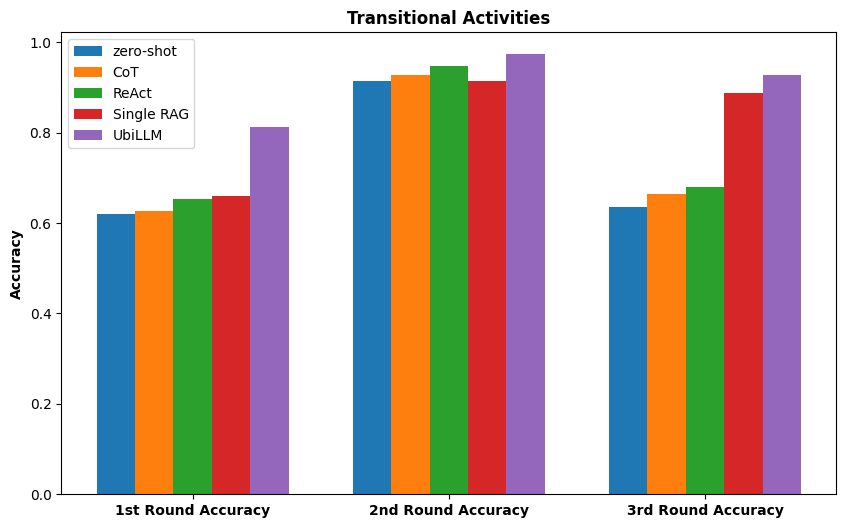

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['1st Round Accuracy', '2nd Round Accuracy', '3rd Round Accuracy']
accuracy_data = {
    # 'zero-shot': [0.6530, 0.927, 0.680],
    # 'ReAct': [0.6530, 0.927, 0.680],
    'zero-shot': [0.62, 0.915, 0.635],
    'CoT': [0.627, 0.927, 0.663],
    'ReAct':[0.6530, 0.947, 0.680],
    'Single RAG': [0.66, 0.913, 0.887],
    'UbiLLM': [0.813, 0.973, 0.927]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Accuracy of each round', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Transitional Activities', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('trans_plot.pdf')
plt.show()


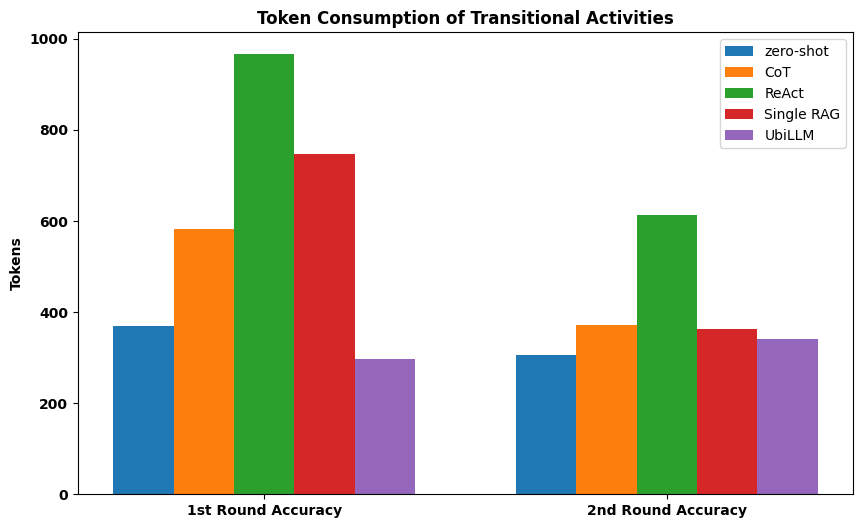

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['zero-shot', 'CoT', 'ReAct', 'Single RAG', 'UbiLLM']
rounds = ['1st Round Accuracy', '2nd Round Accuracy']
accuracy_data = {
    'zero-shot': [369, 305],
    'CoT': [583, 372],
    'ReAct': [966, 614],
    'Single RAG': [746, 363],
    'UbiLLM': [297, 340]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.15  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(10, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Token consumption of each round')
#bold the x and y labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylabel('Tokens', fontweight='bold')
plt.title('Token Consumption of Transitional Activities', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('TAP_token_plot.pdf')
plt.show()

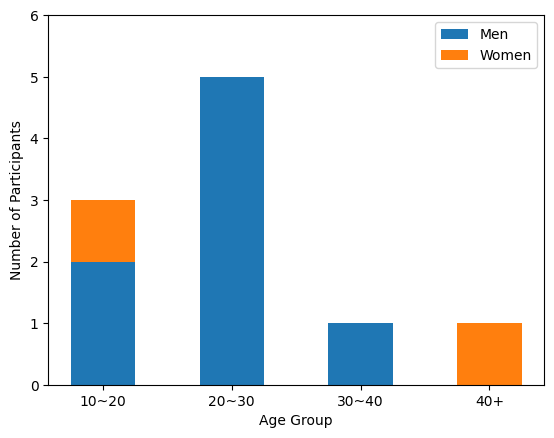

In [26]:
labels = ['10~20', '20~30', '30~40', '40+']
men_means = [2, 5, 1, 0]
women_means = [1, 0, 0, 1]
width = 0.5

p1 = plt.bar(labels, men_means, width, label='Men')
p2 = plt.bar(labels, women_means, width, bottom=men_means, label='Women')

plt.ylim(0, 6)
# plt.title('Stacked Bar Chart')
plt.xlabel('Age Group')
plt.ylabel('Number of Participants')
plt.legend()
plt.savefig('participant.pdf')
plt.show()